<a href="https://colab.research.google.com/github/arjnmj/ML-Fraud-Detection/blob/main/XGB_DATASET2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/card_transdata.csv')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


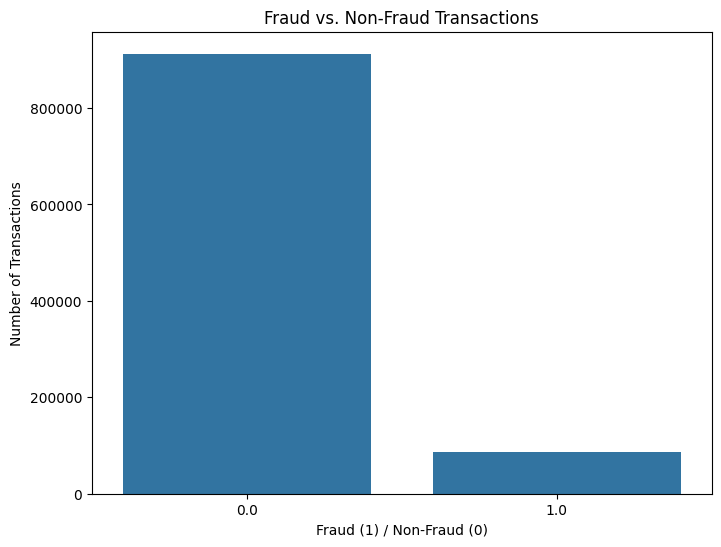

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='fraud', data=df)
plt.title('Fraud vs. Non-Fraud Transactions')
plt.xlabel('Fraud (1) / Non-Fraud (0)')
plt.ylabel('Number of Transactions')
plt.show()


In [ ]:
fraud_counts = df['fraud'].value_counts()
print("Number of Fraudulent Transactions:", fraud_counts[1])
print("Number of Non-Fraudulent Transactions:", fraud_counts[0])


Number of Fraudulent Transactions: 87403
Number of Non-Fraudulent Transactions: 912597


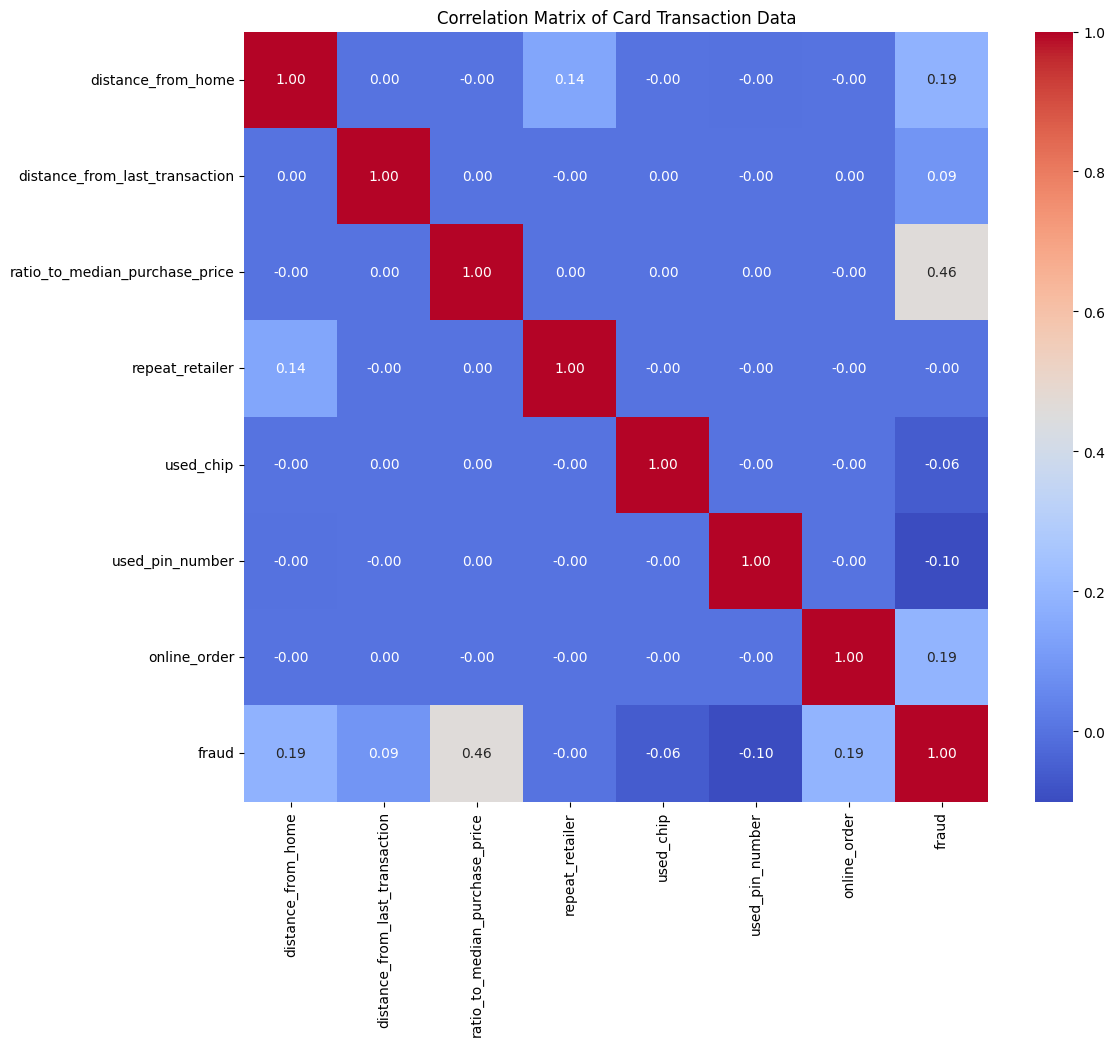

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded as in your previous code
# df = pd.read_csv('/content/drive/MyDrive/card_transdata.csv')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Card Transaction Data')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'fraud' is your target variable
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check the class distribution in the training and testing sets
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


X_train shape: (800000, 7)
y_train shape: (800000,)
X_test shape: (200000, 7)
y_test shape: (200000,)

Class distribution in y_train:
fraud
0.0    0.912597
1.0    0.087402
Name: proportion, dtype: float64

Class distribution in y_test:
fraud
0.0    0.912595
1.0    0.087405
Name: proportion, dtype: float64


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with optimized hyperparameters
xgb_classifier = XGBClassifier(
    n_estimators=600,  # Adjust the number of estimators
    max_depth=8,        # Adjust the maximum depth of trees
    learning_rate=0.01, # Adjust the learning rate
    scale_pos_weight = 20, # address class imbalance
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    eval_metric=['auc', 'aucpr', 'logloss']
    # Add more hyperparameters as needed
)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"F2-score: {f2}")


Precision: 0.9754423173522353
Recall: 0.999771180138436
F1-score: 0.9874569184699701
F2-score: 0.9948088022677337


In [ ]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Find the best threshold based on desired precision (e.g., 0.99)
best_threshold = None
for i in range(len(thresholds)):
  if precision[i] >= 0.99:
      best_threshold = thresholds[i]
      break

if best_threshold is not None:
  print(f"Best threshold for >= 0.99 precision: {best_threshold}")

  # Make predictions based on the best threshold
  y_pred_best = (y_pred_prob >= best_threshold).astype(int)

  # Calculate metrics with the best threshold
  precision_best = precision_score(y_test, y_pred_best)
  recall_best = recall_score(y_test, y_pred_best)

  print(f"Precision at best threshold: {precision_best}")
  print(f"Recall at best threshold: {recall_best}")
else:
    print("No threshold found that achieves 0.99 precision.")


Best threshold for >= 0.99 precision: 0.9244681000709534
Precision at best threshold: 0.9900463360219667
Recall at best threshold: 0.9900463360219667


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       1.00      1.00      1.00    200000



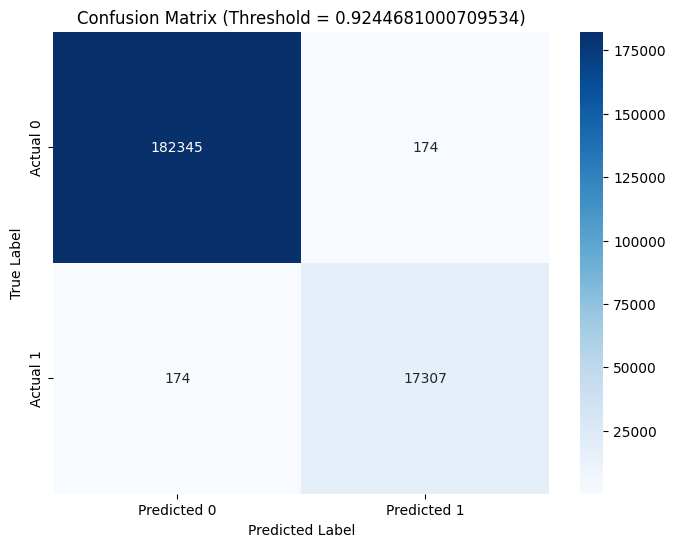

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred_prob are already defined from your previous code

# Use the specified threshold
threshold = 0.9244681000709534
y_pred_new = (y_pred_prob >= threshold).astype(int)

# Classification Report
print(classification_report(y_test, y_pred_new))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Threshold = {})'.format(threshold))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score
metrics = [['Accuracy',(accuracy_score(y_test, y_pred_new))],
                         ['Precision',precision_score(y_test, y_pred_new)],
                         ['Recall', recall_score(y_test, y_pred_new)],
                         ['F1_score',f1_score(y_test, y_pred_new)]]
metrics_df = pd.DataFrame(metrics, columns = ['Metrics', 'Results'])
metrics_df


,Metrics,Results
0,Accuracy,0.998260
1,Precision,0.990046
2,Recall,0.990046
3,F1_score,0.990046


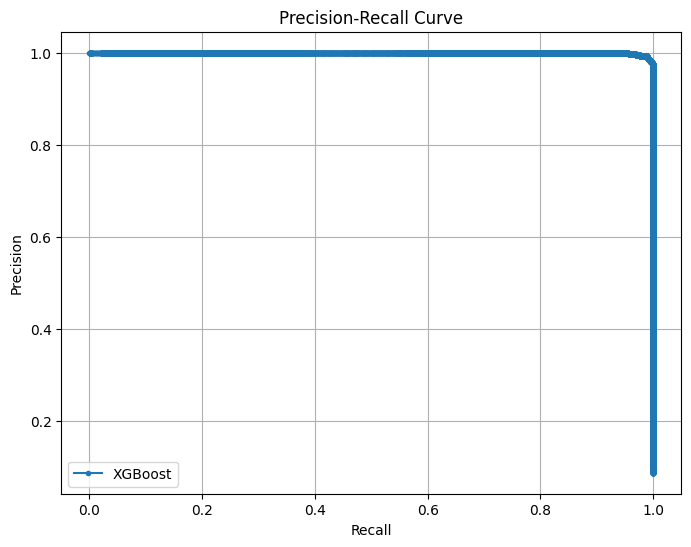

In [ ]:
# prompt: pr curve for that

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


                          Feature  Importance
6                    online_order    0.430574
2  ratio_to_median_purchase_price    0.246659
0              distance_from_home    0.086952
4                       used_chip    0.067858
3                 repeat_retailer    0.065976
5                 used_pin_number    0.062503
1  distance_from_last_transaction    0.039478


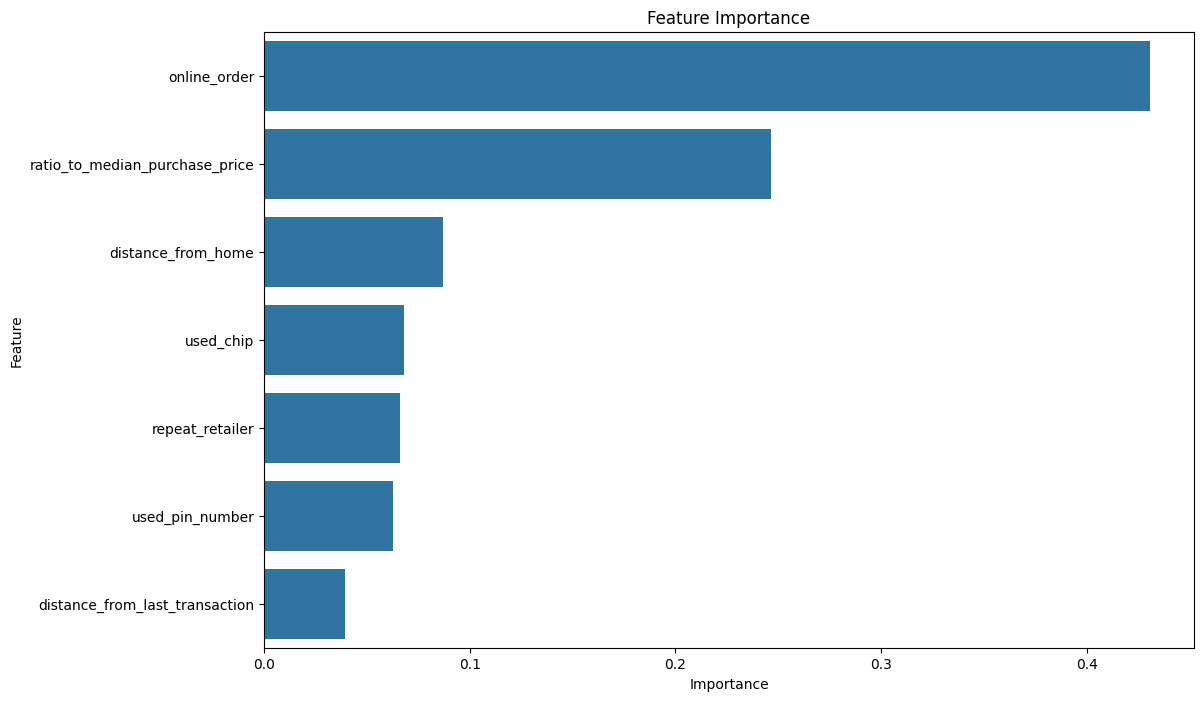

In [ ]:
# prompt: feature importance for predicting

# Access feature importances from the trained XGBoost model
feature_importances = xgb_classifier.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

# Create a bar plot of feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# prompt: export it with threshold value for backend use pickle

import pickle
# Assuming 'xgb_classifier' and 'best_threshold' are already defined
# ... (your existing code) ...

# Create a dictionary to store the model and threshold
model_data = {
    'model': xgb_classifier,
    'threshold': best_threshold
}


# Export the model and threshold using pickle
with open('fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)
